## Custom iteration in Python: a use case with Pandas.

Python offers convenient ways to programmatically define how to iterate on structures.

Before going further, be sure to understand (know how to explain):
 - what an iterable structure is in Python;
 - how the yield keyword works.
 
We will work in this notebook with the following data, representing trajectories supervising the Tour de France cycling race:

In [1]:
import pandas as pd

df = pd.read_json("../data/tour_de_france.json.gz")
df.shape

(53398, 9)

Let's have a look at a sample of this data. Two columns will be of interest to us:
- `icao24` is an hexadecimal identifier of the transponder of the aircraft.  
  It is (almost) equivalent to its tail number;
- `callsign` is what appears on the radar screen of the air traffic controller.  
  It corresponds to a mission, or for a commercial flight, to a commercial flight number. It is not enough to identify a flight as the same callsign may be reused over several days or even sometimes in the same day.

In [2]:
df.sample(10)

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude
47304,2019-07-18 09:45:50,39b861,43.584702,1.365879,179.000000,223.000000,0.0,PXR31M,11000.0
25633,2019-07-20 11:47:00,3924a4,42.938095,0.099643,174.771128,300.232839,0.0,ASR172B,26975.0
21875,2019-07-18 14:36:20,3924a4,42.996368,0.208804,129.321194,309.351753,0.0,ASR172B,24900.0
35268,2019-07-27 13:54:50,3924a4,45.390666,6.528625,188.162002,113.158607,0.0,ASR172B,26000.0
52820,2019-07-18 12:16:40,39bd17,42.911967,0.360505,128.666667,142.666667,0.0,PXR26M,10000.0
20112,2019-07-18 09:42:30,3924a4,43.563812,1.385235,209.480128,144.716686,0.0,ASR172B,24900.0
14575,2019-07-14 10:33:40,3924a4,45.485046,4.352286,178.630750,237.110598,0.0,ASR172B,26975.0
36452,2019-07-28 16:08:50,3924a4,48.628095,1.820333,199.203242,110.422333,0.0,ASR172B,26975.0
45114,2019-07-12 10:32:00,39b861,47.429184,6.639381,138.000000,306.000000,0.0,PXR31M,12000.0
42957,2019-07-25 10:42:30,399675,44.392822,6.644360,201.000000,186.000000,0.0,ASR171A,24000.0


All data for all trajectories has been flattened in one single dataframe.

<div class='alert alert-warning'>
    <b>Exercice:</b> Let's write an <code>iterate_callsign(data)</code> function that will <em>yield</em> one sub-dataframe for each callsign.
</div>

In [4]:
# %load ../solutions/pandas_iterate/iterate_callsign.py

Let's check the first and last timestamp recorded for this subset:

In [5]:
elt = next(iterate_callsign(df))
elt.timestamp.min(), elt.timestamp.max()

(Timestamp('2019-07-12 09:04:50'), Timestamp('2019-07-25 15:34:30'))

In [6]:
elt.agg(dict(timestamp=["min", "max"]))

,timestamp
min,2019-07-12 09:04:50
max,2019-07-25 15:34:30


In the end wrote a function that splits our dataframe by callsign (= mission code), but it is obviously not enough to separate trajectories flying over several days.

We may count how many trajectories we found:

In [7]:
sum(1 for _ in iterate_callsign(df))

4

For comparison with other ways to iterate, let's use this convenient aggregation method: it seems our dataset is heavily unbalanced with a lot of `ASR172B` flights.

In [8]:
df.groupby("callsign").agg(dict(timestamp=["count", "min", "max"]))

timestamp                                        
             count                 min                 max
callsign                                                  
ASR171A       6940 2019-07-12 09:04:50 2019-07-25 15:34:30
ASR172B      37770 2019-07-09 09:24:40 2019-07-28 19:48:20
PXR26M        2263 2019-07-18 07:35:50 2019-07-18 13:52:50
PXR31M        6425 2019-07-12 09:24:40 2019-07-25 15:34:30

A smarter way to iterate may be to use both `icao24` code and `callsign` for building our iteration method.

<div class='alert alert-warning'>
    <b>Exercice:</b> Let's write an <code>iterate_icao24_callsign(data)</code> function that will <em>yield</em> one sub-dataframe for each icao24/callsign pair. Count how many elements you get.
</div>

In [12]:
# %load ../solutions/pandas_iterate/iterate_icao24_callsign.py


Let's compare the groups we managed to produce.

In [13]:
df.groupby(["icao24", "callsign"]).agg(dict(timestamp=["count", "min", "max"]))

timestamp                                        
                    count                 min                 max
icao24 callsign                                                  
3924a0 ASR172B       2524 2019-07-25 08:29:40 2019-07-25 15:30:10
3924a4 ASR172B      35246 2019-07-09 09:24:40 2019-07-28 19:48:20
399675 ASR171A       6940 2019-07-12 09:04:50 2019-07-25 15:34:30
39b861 PXR31M        6425 2019-07-12 09:24:40 2019-07-25 15:34:30
39bd17 PXR26M        2263 2019-07-18 07:35:50 2019-07-18 13:52:50

With this new method, we managed to separate one `ASR172B` mission that has been flown with a different aircraft on July 25th. But we are still being inefficient for the other ones.

<div class='alert alert-warning'>
    <b>Exercice:</b> Let's store in the <code>bigger_chunk</code> variable all data associated to an `icao24` code equal to 3924a4.
</div>

In [16]:
# %load ../solutions/pandas_iterate/bigger_chunk.py


<div class='alert alert-warning'>
    <b>Exercice:</b> Suggest a way to plot how timestamps are distributed in July.
</div>

In [19]:
# %load ../solutions/pandas_iterate/bigger_chunk_plot.py


What your plot should suggest is that these aircraft do not continuously fly. They are recording data continuously throughout the month but have long breaks in between (most probably night time)

Let's see how much time is left between two consecutive timestamps:

<AxesSubplot:ylabel='Frequency'>

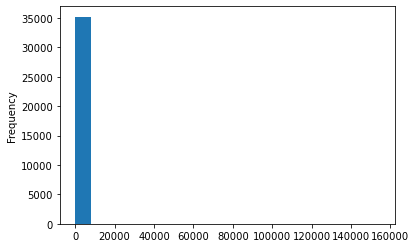

In [20]:
bigger_chunk.timestamp.diff().dt.total_seconds().plot.hist(bins=20)

Of course, for most samples, we get a decent sampling of the trajectory, hence the high density toward zero. 

We may adapt the command to plot the density of higher timestamp differences:

<AxesSubplot:ylabel='Frequency'>

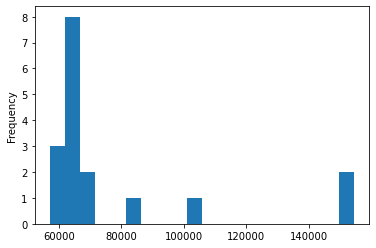

In [21]:
bigger_chunk.timestamp.diff().dt.total_seconds().loc[lambda x: x > 100].plot.hist(bins=20)

This means that trajectories are separated by at least 60000 seconds (about 17 hours). We can use this idea to better iterate on our data. Let's set an arbitrary threshold (to be passed in parameter, but we could start with 20000 for instance), and yield chunks of the `bigger_chunk` dataset corresponding to consecutive timestamps.

<div class='alert alert-warning'>
    <b>Exercice:</b> Write an <code>iterate_time(data, threshold)</code> function that yields pieces of trajectories corresponding to consecutive timestamps of less than threshold seconds.
</div>

In [1]:
# %load ../solutions/pandas_iterate/iterate_time.py
import numpy as np

def iterate_time(data, threshold):
    idx = np.where(data.timestamp.diff().dt.total_seconds() > threshold)[0]
    start = 0
    for stop in idx:
        yield data.iloc[start:stop]
        start = stop
    yield data.iloc[start:]


See how many trajectories you get now (on `bigger_chunk`, i.e. aircraft `3924a4`):

In [26]:
sum(1 for _ in iterate_time(bigger_chunk, 20000))

18

In [27]:
list(
    (str(chunk.timestamp.min()), str(chunk.timestamp.max()))
    for chunk in iterate_time(bigger_chunk, 20000)
)

[('2019-07-09 09:24:40', '2019-07-09 16:15:30'),
 ('2019-07-10 10:12:20', '2019-07-10 16:06:40'),
 ('2019-07-11 10:14:30', '2019-07-11 16:36:50'),
 ('2019-07-12 08:29:00', '2019-07-12 15:42:10'),
 ('2019-07-13 09:25:10', '2019-07-13 16:10:10'),
 ('2019-07-14 10:11:40', '2019-07-14 16:18:10'),
 ('2019-07-15 09:18:30', '2019-07-15 15:48:30'),
 ('2019-07-17 10:43:50', '2019-07-17 13:11:50'),
 ('2019-07-18 09:02:40', '2019-07-18 15:15:00'),
 ('2019-07-19 07:27:10', '2019-07-19 16:10:10'),
 ('2019-07-20 10:42:40', '2019-07-20 15:50:10'),
 ('2019-07-21 09:17:30', '2019-07-21 16:07:00'),
 ('2019-07-23 10:30:20', '2019-07-23 16:10:40'),
 ('2019-07-24 09:32:40', '2019-07-24 11:42:00'),
 ('2019-07-25 17:00:10', '2019-07-25 17:31:10'),
 ('2019-07-26 10:45:30', '2019-07-26 15:52:50'),
 ('2019-07-27 11:30:40', '2019-07-27 15:53:20'),
 ('2019-07-28 14:50:10', '2019-07-28 19:48:20')]

<div class='alert alert-warning'>
    <b>Wrap it up!</b> Write an <code>iterate_all(data, threshold)</code> function that combines iteration on aircraft icao24, callsign and timestamp intervals.
</div>

In [31]:
# %load ../solutions/pandas_iterate/iterate_all.py



In [32]:
sum(1 for _ in iterate_all(df, 20000))

26

You may now build a summary table like the following.

<div class="alert alert-danger">
    <b>Be sure to fully understand this notebook!</b> We will be using these results during next session.
</div>

In [33]:
pd.DataFrame.from_records(
    [
        {
            "icao24": chunk.icao24.min(),
            "callsign": chunk.callsign.min(),
            "start": chunk.timestamp.min(),
            "stop": chunk.timestamp.max(),
        }
        for chunk in iterate_all(df, 20000)
    ]
)

,icao24,callsign,start,stop
0,3924a0,ASR172B,2019-07-25 08:29:40,2019-07-25 15:30:10
1,3924a4,ASR172B,2019-07-09 09:24:40,2019-07-09 16:15:30
2,3924a4,ASR172B,2019-07-10 10:12:20,2019-07-10 16:06:40
3,3924a4,ASR172B,2019-07-11 10:14:30,2019-07-11 16:36:50
4,3924a4,ASR172B,2019-07-12 08:29:00,2019-07-12 15:42:10
5,3924a4,ASR172B,2019-07-13 09:25:10,2019-07-13 16:10:10
6,3924a4,ASR172B,2019-07-14 10:11:40,2019-07-14 16:18:10
7,3924a4,ASR172B,2019-07-15 09:18:30,2019-07-15 15:48:30
8,3924a4,ASR172B,2019-07-17 10:43:50,2019-07-17 13:11:50
9,3924a4,ASR172B,2019-07-18 09:02:40,2019-07-18 15:15:00
